# Creating a Model Grid from Vector Extents

Use GDAL to rasterize a vector extent of CONUS.

In [ ]:
import os

import geopandas as gpd
import pandas as pd
import shapely
from dotenv import load_dotenv
from osgeo.gdal import GDT_Byte

from trainer import rasterize

load_dotenv()

True

In [2]:

# specified for example; issue with GDAL bindings in uv
os.environ['PROJ_LIB'] = '../.venv/lib/python3.12/site-packages/osgeo/data/proj'


In [ ]:
# paths and constants
input_vector = 's3://fim-services-data/f1/data/tl_2024_us_state.gpkg'
output_vector = 'data/conus_geom.gpkg'
output_raster = 'data/conus.tif'
no_data_value = 8 # highest number in gdal.GDT_Byte, allows us to do 0 and 1 for land and extent
crs = 'EPSG:6350'
buffer_size = 1000 # in unit of projection (meters)

Use geopandas to process an input of all US States. Remove defined non-CONUS states, reproject to equal area projection, dissolve polygons into single polygon, export with a single value, and create an inverse of the polygon for the bounding box to have data in the output raster.


In [4]:
gdf = gpd.read_file(input_vector, immutable='YES')

# remove non-CONUS states/territories
gdf = gdf.loc[~gdf['GEOID'].isin(['15','78','69', '66', '62', '02', '60', '72'])]

# reproject NAD83(2011) Albers Equal Area
gdf = gdf.to_crs(crs)

# dissolve to one polygon and set value to same value
gdf = gdf.dissolve()
gdf = gdf[['geometry']]
gdf['value'] = 1

# buffer
gdf['geometry'] = gdf['geometry'].buffer(buffer_size)

# add an extent for the inverse of the polygon
bounds = gdf['geometry'].bounds.iloc[0]
conus_geom = gdf['geometry'].iloc[0]
box = shapely.geometry.box(bounds['minx'],bounds['miny'], bounds['maxx'], bounds['maxy'])
erased_box = (box.symmetric_difference(conus_geom)).difference(conus_geom)

# concat to have inside and outside
gdf = pd.concat([gdf, (gpd.GeoDataFrame(geometry=[erased_box], data={'value':[0]}, crs=crs))])



<Axes: >

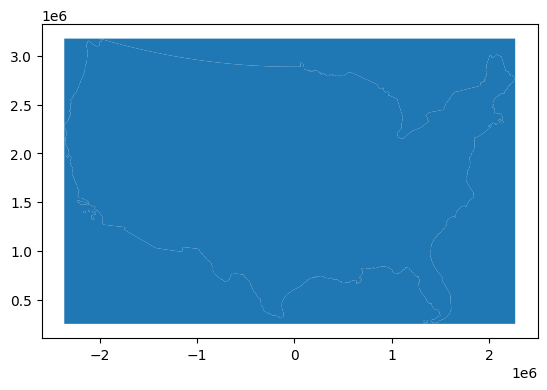

In [5]:
gdf.plot()

In [6]:
gdf.to_file(output_vector, layer='conus')

Use GDAL to create raster from vector

In [7]:

rasterize(output_vector, output_raster, pixel_size=250, attribute='value', no_data_value=no_data_value, output_type=GDT_Byte)

/home/quercus/code/hy/f1_trainer/.venv/lib/python3.12/site-packages/osgeo/ogr.py:604: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
